In [4]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score,
    roc_curve, brier_score_loss
)
from sklearn.calibration import calibration_curve

# Import custom models
# Removed old path hack; using package imports))
from llm_prior_project.priors.target_informed_model import TargetInformedModel
from llm_prior_project.priors.target_elicitor import LLMTargetElicitor

np.random.seed(42)


In [15]:
# loading the data 
def load_heart_dataset(path, features, outcome="num"):
    columns = [
        "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
        "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"
    ]
    df = pd.read_csv(path, header=None, names=columns, na_values="?")
    df[outcome] = (df[outcome] > 0).astype(int)
    df = df[features + [outcome]].dropna()
    return df[features], df[outcome]

features = ["age", "sex", "trestbps", "chol", "thalach", "oldpeak", "cp", "exang", "fbs", "restecg"]

X_hun, y_hun = load_heart_dataset("data/heart+disease/processed.hungarian.data", features)
X_clev, y_clev = load_heart_dataset("data/heart+disease/processed.cleveland.data", features)



X_hun = pd.get_dummies(X_hun, columns=["cp", "restecg"], drop_first=True).astype(float)
X_clev = pd.get_dummies(X_clev, columns=["cp", "restecg"], drop_first=True).astype(float)

# Clean up dummy column names once, right after pd.get_dummies
X_hun = X_hun.rename(columns=lambda c: c.replace(".0", ""))
X_clev = X_clev.rename(columns=lambda c: c.replace(".0", ""))


features = list(X_hun.columns)

print("Hungarian:", X_hun.shape, "Cleveland:", X_clev.shape)


Hungarian: (261, 13) Cleveland: (303, 13)


In [16]:
import numpy as np

def llm_predict_proba(X, beta, beta0=0.0):
    """
    Logistic regression predictor with fixed coefficients (LLM-specified).
    X: pd.DataFrame or np.array with shape (n_samples, n_features)
    beta: array-like of length n_features
    beta0: intercept
    Returns: np.array of probabilities (n_samples,)
    """
    X_arr = np.asarray(X)
    beta = np.asarray(beta)
    z = beta0 + np.dot(X_arr, beta)
    return 1 / (1 + np.exp(-z))


In [17]:
import pandas as pd

# Assuming you still have X_clev, y_clev with "sex" among the features
# (0 = female, 1 = male)

# 🔹 1. Split by subgroup
mask_male = X_clev["sex"] == 1
mask_female = X_clev["sex"] == 0

X_male, y_male = X_clev[mask_male].drop(columns=["sex"]), y_clev[mask_male]
X_female, y_female = X_clev[mask_female].drop(columns=["sex"]), y_clev[mask_female]

print("Male group:", X_male.shape, "Female group:", X_female.shape)

# 🔹 2. Define train/test splits

# Experiment 1: Train on males, evaluate on females
X_train_1, y_train_1 = X_male, y_male
X_test_1, y_test_1   = X_female, y_female

# Experiment 2: Train on females, evaluate on males
X_train_2, y_train_2 = X_female, y_female
X_test_2, y_test_2   = X_male, y_male



Male group: (206, 12) Female group: (97, 12)


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

logreg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
rf = RandomForestClassifier(n_estimators=200, random_state=42)
gb = GradientBoostingClassifier(random_state=42)


In [19]:
def ensemble_predict(X, models, weights):
    probs = [m.predict_proba(X)[:, 1] for m in models]
    P = np.column_stack(probs)
    return P @ weights

# Optimizer

In [20]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import log_loss

def optimize_ensemble_weights(probs_list, y_val):
    """
    probs_list: list of arrays, each shape (N,), model probabilities for class 1
    y_val:      array shape (N,), binary labels
    """
    P = np.column_stack(probs_list)
    M = P.shape[1]
    w0 = np.ones(M) / M  # start with equal weights

    # Objective = log loss of weighted probs
    def objective(w):
        p = np.clip(P @ w, 1e-12, 1-1e-12)
        return log_loss(y_val, p)

    # Constraints: weights sum to 1
    cons = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
    bounds = [(0, 1)] * M

    res = minimize(objective, w0, bounds=bounds, constraints=cons)
    return res.x, res.fun  # optimal weights, final loss


In [21]:
def run_out_of_group_experiment(X_train, y_train, X_test, y_test):
    # Split train into subtrain/val (for weight optimization)
    X_subtrain, X_val, y_subtrain, y_val = train_test_split(
        X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
    )

    # Fit base models
    models = [logreg, rf, gb]
    for m in models:
        m.fit(X_subtrain, y_subtrain)

    # Get validation probs
    probs_val = [m.predict_proba(X_val)[:, 1] for m in models]

    # Optimize weights
    weights_opt, best_loss = optimize_ensemble_weights(probs_val, y_val)
    print("Optimal weights:", weights_opt)
    print("Validation log loss:", best_loss)

    # Evaluate on test set
    for m, name in zip(models, ["LogReg", "RF", "GB"]):
        p_test = m.predict_proba(X_test)[:, 1]
        print(f"{name} ROC AUC:", roc_auc_score(y_test, p_test))

    p_test_ens = ensemble_predict(X_test, models, weights_opt)
    y_pred = (p_test_ens > 0.5).astype(int)

    print("\nOptimized ensemble performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, p_test_ens))
    print("Log loss:", log_loss(y_test, p_test_ens))
    return weights_opt

In [22]:
print("=== Train on males → Test on females ===")
weights_male_to_female = run_out_of_group_experiment(X_male, y_male, X_female, y_female)

print("\n=== Train on females → Test on males ===")
weights_female_to_male = run_out_of_group_experiment(X_female, y_female, X_male, y_male)


=== Train on males → Test on females ===
Optimal weights: [0.         0.95976272 0.04023728]
Validation log loss: 0.45174725917962905
LogReg ROC AUC: 0.8722222222222223
RF ROC AUC: 0.871388888888889
GB ROC AUC: 0.8166666666666667

Optimized ensemble performance:
Accuracy: 0.7319587628865979
ROC AUC: 0.87
Log loss: 0.5467871252857426

=== Train on females → Test on males ===


Optimal weights: [0.04377822 0.95622178 0.        ]
Validation log loss: 0.3999926720613379
LogReg ROC AUC: 0.8342868039664378
RF ROC AUC: 0.8018688024408849
GB ROC AUC: 0.6590389016018307

Optimized ensemble performance:
Accuracy: 0.6456310679611651
ROC AUC: 0.8043478260869565
Log loss: 0.79056595863202


In [23]:
ALL_FEATURES = [
    "age", "trestbps", "chol", "thalach", "oldpeak",  # continuous (z-scored)
    "exang", "fbs",                            # binary
    "cp_2", "cp_3", "cp_4",                           # chest pain dummies
    "restecg_1", "restecg_2"                      # restecg dummies
]


features = ALL_FEATURES
llm_betas_dict = {
    "intercept": -0.85,
    "age": 0.60,
    "trestbps": 0.20,
    "chol": 0.12,
    "thalach": -0.50,
    "oldpeak": 0.55,
    "exang": 0.60,
    "fbs": 0.35,
    "cp_2": -0.40,
    "cp_3": -0.80,
    "cp_4": 0.60,
    "restecg_1": 0.25,
    "restecg_2": 0.45,
}


beta0_llm = llm_betas_dict["intercept"]
beta_llm = np.array([llm_betas_dict[feat] for feat in features], dtype=float)

In [73]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.optimize import minimize

# Base models (LR scaled; trees unscaled)
logreg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
rf = RandomForestClassifier(n_estimators=200, random_state=42)
gb = GradientBoostingClassifier(random_state=42)

def redistribute_weights(w_base, alpha):
    w_non_llm = np.array(w_base[:-1])
    w_non_llm = (1 - alpha) * w_non_llm / w_non_llm.sum()
    return np.concatenate([w_non_llm, [alpha]])


# General optimizer: optionally FIX one weight (e.g., LLM=alpha)
def optimize_convex_weights(probs_list, y_val, fixed_index=None, fixed_value=None, l2=0.0):
    """
    probs_list: list of (N,) arrays for each model's p(y=1) on validation
    y_val:      (N,) labels
    fixed_index: index of the weight to fix (e.g., LLM)
    fixed_value: value to fix that weight to (alpha)
    l2:         optional small L2 on weights for stability
    """
    P = np.column_stack(probs_list)         # (N, M)
    M = P.shape[1]
    w0 = np.ones(M) / M

    def objective(w):
        p = np.clip(P @ w, 1e-12, 1-1e-12)
        loss = log_loss(y_val, p)
        if l2 > 0:
            loss += l2 * np.sum(w**2)
        return loss

    bounds = [(0.0, 1.0)] * M
    cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}]  # sum-to-1

    if fixed_index is not None and fixed_value is not None:
        # Add equality constraint w[fixed_index] = fixed_value
        cons.append({"type": "eq", "fun": lambda w, i=fixed_index, v=fixed_value: w[i] - v})

    res = minimize(objective, w0, method="SLSQP", bounds=bounds, constraints=cons,
                   options={"maxiter": 1000, "ftol": 1e-9})
    if not res.success:
        print("Warning: weight optimization did not fully converge:", res.message)
    return res.x, res.fun

# Utility: predict with convex weights
def convex_ensemble_proba(P_matrix, weights):
    # P_matrix: (N, M) stacked model probs (including LLM as last column)
    return np.clip(P_matrix @ weights, 1e-12, 1-1e-12)

# ---------- Main runner: include LLM from the start + alpha sweep ----------
def run_oog_with_llm_alpha_sweep(
    X_train, y_train, X_test, y_test,
    beta_llm, beta0_llm,
    alpha_range=(0.0, 0.7, 15),          # (start, stop, num_points)
    llm_feature_order=None,              # e.g., list of columns for the LLM, or None if same as X
    l2=0.0
):
    """
    Train LR/RF/GB on X_train, optimize convex weights for 4-model ensemble (LLM included),
    then sweep alpha for LLM by fixing w_LLM=alpha and re-optimizing the other weights.
    Returns a DataFrame with alpha, weights (w_LR, w_RF, w_GB, w_LLM), and metrics.
    """
    # Split train into subtrain/val for weight optimization
    X_subtrain, X_val, y_subtrain, y_val = train_test_split(
        X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
    )

    # Fit base models on subtrain
    models = [logreg, rf, gb]
    for m in models:
        m.fit(X_subtrain, y_subtrain)

    # ----- Get validation probabilities for LR/RF/GB -----
    probs_val_ml = [m.predict_proba(X_val)[:, 1] for m in models]

    # ----- LLM probabilities on val/test (align features if needed) -----
    X_val_llm  = X_val[llm_feature_order]  if llm_feature_order is not None else X_val
    X_test_llm = X_test[llm_feature_order] if llm_feature_order is not None else X_test

    p_llm_val  = llm_predict_proba(X_val_llm,  beta_llm, beta0_llm)
    p_llm_test = llm_predict_proba(X_test_llm, beta_llm, beta0_llm)

    # Stack ML + LLM (LLM is last column, index = 3)
    P_val  = np.column_stack(probs_val_ml + [p_llm_val])
    P_test = np.column_stack([m.predict_proba(X_test)[:, 1] for m in models] + [p_llm_test])

    # ----- Baselines -----
    # A) Best 4-model unconstrained (LLM free to take any share)
    w4_free, val_loss4 = optimize_convex_weights([*probs_val_ml, p_llm_val], y_val, fixed_index=None, fixed_value=None, l2=l2)
    p_test_4free = convex_ensemble_proba(P_test, w4_free)

    # B) 3-model baseline = alpha=0 (fix w_LLM=0)
    w3_at_alpha0, val_loss3 = optimize_convex_weights([*probs_val_ml, p_llm_val], y_val, fixed_index=3, fixed_value=0.0, l2=l2)
    p_test_3only = convex_ensemble_proba(P_test, w3_at_alpha0)

    # Collect results
    rows = []
    def add_row(label, alpha, w, p):
        rows.append({
            "label": label,
            "alpha": alpha,
            "w_LR":  w[0],
            "w_RF":  w[1],
            "w_GB":  w[2],
            "w_LLM": w[3],
            "accuracy": accuracy_score(y_test, (p > 0.5).astype(int)),
            "auc":      roc_auc_score(y_test, p),
            "logloss":  log_loss(y_test, p)
        })

    add_row("baseline_3_only(alpha=0)", 0.0, w3_at_alpha0, p_test_3only)
    add_row("best_4_free",               w4_free[3], w4_free, p_test_4free)

    # ----- α-sweep: fix w_LLM=alpha; subtract from the other three -----
    alphas = np.linspace(*alpha_range)
    for alpha in alphas:
        w_alpha = redistribute_weights(w4_free, alpha)
        p_alpha = convex_ensemble_proba(P_test, w_alpha)
        add_row("sweep", float(alpha), w_alpha, p_alpha)


    df = pd.DataFrame(rows)
    return df



In [74]:
ALL_FEATURES = [
    "age", "trestbps", "chol", "thalach", "oldpeak",
    "exang", "fbs",
    "cp_2", "cp_3", "cp_4",
    "restecg_1", "restecg_2"
]

llm_betas_dict_male = {
    "intercept": -0.85,
    "age": 0.9,
    "trestbps": 0.3,
    "chol": 0.15,
    "thalach": -0.7,
    "oldpeak": 0.8,
    "exang": 1.0,
    "fbs": 0.25,
    "cp_2": -0.7,
    "cp_3": -0.4,
    "cp_4": 0.9,
    "restecg_1": 0.2,
    "restecg_2": 0.35,
}

beta0_llm_male_train = llm_betas_dict_male["intercept"]
beta_llm_male_train = np.array([llm_betas_dict_male[feat] for feat in ALL_FEATURES], dtype=float)


In [75]:
llm_betas_dict_female = {
    "intercept": -2.197,
    "age": 0.95,
    "trestbps": 0.30,
    "chol": 0.08,
    "thalach": -0.65,
    "oldpeak": 0.90,
    "exang": 0.40,
    "fbs": 0.75,
    "cp_2": -0.10,
    "cp_3": -0.35,
    "cp_4": 0.25,
    "restecg_1": 0.12,
    "restecg_2": 0.22,
}

beta0_llm_female_train = llm_betas_dict_female["intercept"]
beta_llm_female_train = np.array([llm_betas_dict_female[feat] for feat in ALL_FEATURES], dtype=float)


In [76]:
df_m_to_f = run_oog_with_llm_alpha_sweep(
    X_male, y_male, X_female, y_female,
    beta_llm_female_train, beta0_llm_female_train,
    alpha_range=(0.0, 0.7, 15),
    llm_feature_order=X_male.columns.tolist(),
    l2=1e-6
)

df_f_to_m = run_oog_with_llm_alpha_sweep(
    X_female, y_female, X_male, y_male,
    beta_llm_male_train, beta0_llm_male_train,
    alpha_range=(0.0, 0.7, 15),
    llm_feature_order=X_female.columns.tolist(),
    l2=1e-6
)


In [77]:
print("=== Male → Female: Best logloss row ===")
print(df_m_to_f.loc[df_m_to_f['logloss'].idxmin()])

print("\n=== Female → Male: Best logloss row ===")
print(df_f_to_m.loc[df_f_to_m['logloss'].idxmin()])


=== Male → Female: Best logloss row ===
label          sweep
alpha            0.0
w_LR             0.0
w_RF             1.0
w_GB             0.0
w_LLM            0.0
accuracy    0.731959
auc         0.871389
logloss     0.545273
Name: 2, dtype: object

=== Female → Male: Best logloss row ===
label          sweep
alpha           0.45
w_LR        0.024169
w_RF        0.525831
w_GB             0.0
w_LLM           0.45
accuracy     0.73301
auc         0.835526
logloss     0.545382
Name: 11, dtype: object


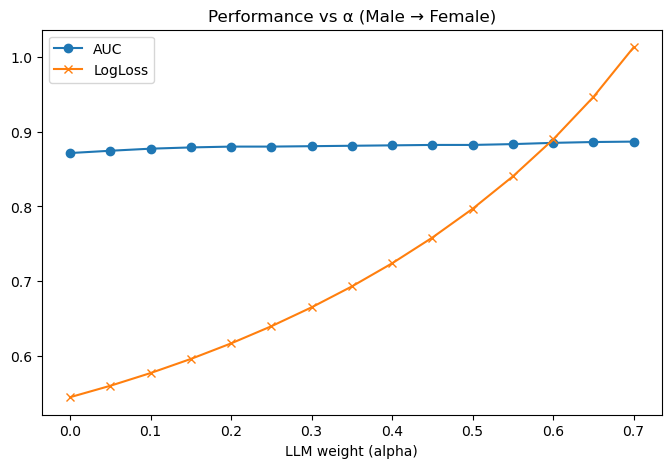

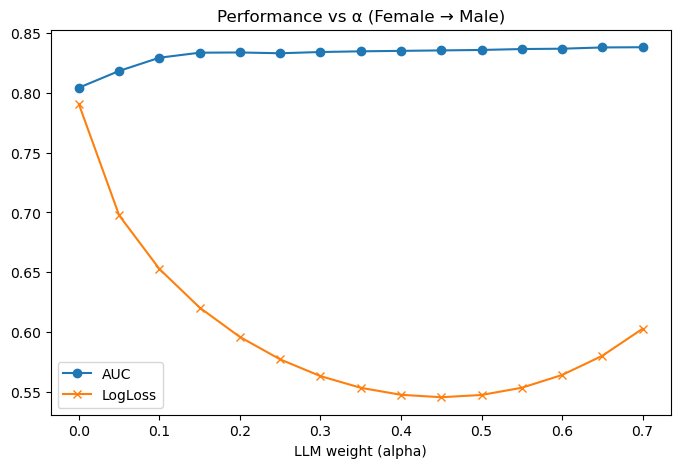

In [78]:
import matplotlib.pyplot as plt

for df, title in [(df_m_to_f, "Male → Female"), (df_f_to_m, "Female → Male")]:
    plt.figure(figsize=(8,5))
    sweep = df[df["label"]=="sweep"]
    plt.plot(sweep["alpha"], sweep["auc"], marker="o", label="AUC")
    plt.plot(sweep["alpha"], sweep["logloss"], marker="x", label="LogLoss")
    plt.xlabel("LLM weight (alpha)")
    plt.title(f"Performance vs α ({title})")
    plt.legend()
    plt.show()


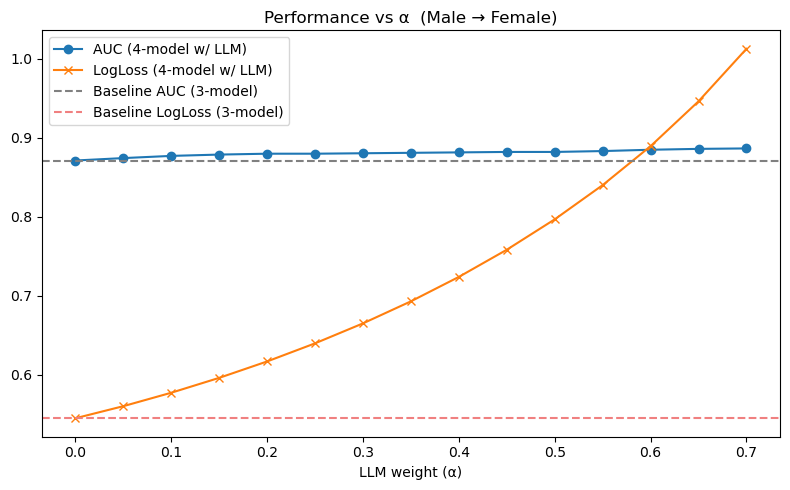

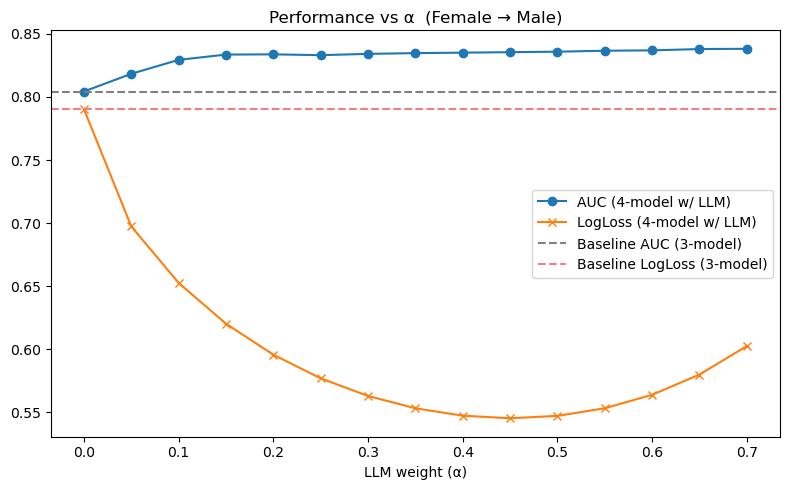

In [79]:
import matplotlib.pyplot as plt

for df, title in [(df_m_to_f, "Male → Female"), (df_f_to_m, "Female → Male")]:
    plt.figure(figsize=(8,5))
    
    # Extract the sweep rows (α-sweep)
    sweep = df[df["label"] == "sweep"].copy().sort_values("alpha")

    # Baseline 3-model metrics (α = 0, no LLM)
    auc_base = df.loc[df["label"] == "baseline_3_only(alpha=0)", "auc"].iloc[0]
    log_base = df.loc[df["label"] == "baseline_3_only(alpha=0)", "logloss"].iloc[0]

    # Plot sweep curves
    plt.plot(sweep["alpha"], sweep["auc"], marker="o", label="AUC (4-model w/ LLM)")
    plt.plot(sweep["alpha"], sweep["logloss"], marker="x", label="LogLoss (4-model w/ LLM)")

    # Add baseline reference lines
    plt.axhline(auc_base, color="gray", linestyle="--", label="Baseline AUC (3-model)")
    plt.axhline(log_base, color="lightcoral", linestyle="--", label="Baseline LogLoss (3-model)")

    plt.xlabel("LLM weight (α)")
    plt.title(f"Performance vs α  ({title})")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# --- Fit logistic models for each group ---
lr_male = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
lr_female = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

lr_male.fit(X_male, y_male)
lr_female.fit(X_female, y_female)

coef_male = lr_male.named_steps["logisticregression"].coef_.flatten()
coef_female = lr_female.named_steps["logisticregression"].coef_.flatten()
features = X_male.columns.tolist()

# --- Build comparison table with both LLM priors ---
coef_compare = pd.DataFrame({
    "feature": features,
    "β_male_data": coef_male,
    "β_female_data": coef_female,
    "β_LLM_male": [float(llm_betas_dict_male.get(f, np.nan)) for f in features],
    "β_LLM_female": [float(llm_betas_dict_female.get(f, np.nan)) for f in features]
})

# Include intercepts
coef_compare.loc[len(coef_compare)] = {
    "feature": "intercept",
    "β_male_data": lr_male.named_steps["logisticregression"].intercept_[0],
    "β_female_data": lr_female.named_steps["logisticregression"].intercept_[0],
    "β_LLM_male": llm_betas_dict_male["intercept"],
    "β_LLM_female": llm_betas_dict_female["intercept"]
}

display(coef_compare)


,feature,β_male_data,β_female_data,β_LLM_male,β_LLM_female
0,age,0.178462,0.424703,0.90,0.950
1,trestbps,0.122289,0.547877,0.30,0.300
2,chol,0.357607,0.053562,0.15,0.080
3,thalach,-0.715842,-0.277913,-0.70,-0.650
4,oldpeak,0.649154,0.732079,0.80,0.900
5,exang,0.185196,0.567440,1.00,0.400
6,fbs,-0.102255,0.410801,0.25,0.750
7,cp_2,0.028235,0.377831,-0.70,-0.100
8,cp_3,0.060348,-0.239762,-0.40,-0.350
9,cp_4,0.866247,1.155656,0.90,0.250


In [81]:
coef_diff = coef_compare.copy()
coef_diff["Δ(LRMale - LLMMale)"] = coef_diff["β_male_data"] - coef_diff["β_LLM_male"]
coef_diff["Δ(FemaleData - LLMMale)"] = coef_diff["β_female_data"] - coef_diff["β_LLM_male"]
coef_diff["SignMismatch"] = np.sign(coef_diff["β_LLM_male"]) != np.sign(coef_diff["β_female_data"])
display(coef_diff)


,feature,β_male_data,β_female_data,β_LLM_male,β_LLM_female,Δ(LRMale - LLMMale),Δ(FemaleData - LLMMale),SignMismatch
0,age,0.178462,0.424703,0.90,0.950,-0.721538,-0.475297,False
1,trestbps,0.122289,0.547877,0.30,0.300,-0.177711,0.247877,False
2,chol,0.357607,0.053562,0.15,0.080,0.207607,-0.096438,False
3,thalach,-0.715842,-0.277913,-0.70,-0.650,-0.015842,0.422087,False
4,oldpeak,0.649154,0.732079,0.80,0.900,-0.150846,-0.067921,False
5,exang,0.185196,0.567440,1.00,0.400,-0.814804,-0.432560,False
6,fbs,-0.102255,0.410801,0.25,0.750,-0.352255,0.160801,False
7,cp_2,0.028235,0.377831,-0.70,-0.100,0.728235,1.077831,True
8,cp_3,0.060348,-0.239762,-0.40,-0.350,0.460348,0.160238,False
9,cp_4,0.866247,1.155656,0.90,0.250,-0.033753,0.255656,False


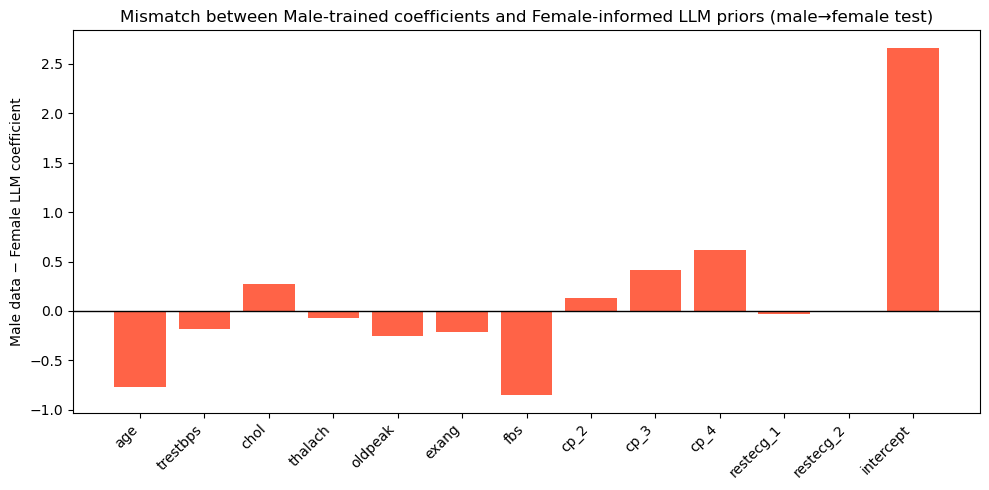

In [82]:
coef_diff = coef_compare.copy()
coef_diff["Δ(MaleData - LLMMFemale)"] = coef_diff["β_male_data"] - coef_diff["β_LLM_female"]
coef_diff["SignMismatch"] = np.sign(coef_diff["β_male_data"]) != np.sign(coef_diff["β_LLM_female"])

plt.figure(figsize=(10,5))
plt.bar(coef_diff["feature"], coef_diff["Δ(MaleData - LLMMFemale)"], color="tomato")
plt.axhline(0, color="black", lw=1)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Male data − Female LLM coefficient")
plt.title("Mismatch between Male-trained coefficients and Female-informed LLM priors (male→female test)")
plt.tight_layout()
plt.show()


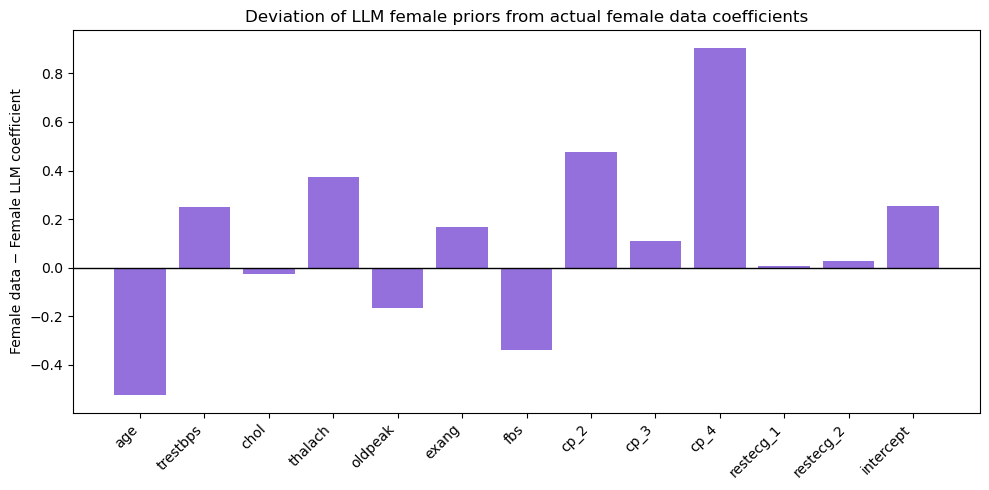

,feature,β_female_data,β_LLM_female,Δ(FemaleData - LLMFemale),SignMismatch
9,cp_4,1.155656,0.250,0.905656,False
0,age,0.424703,0.950,-0.525297,False
7,cp_2,0.377831,-0.100,0.477831,True
3,thalach,-0.277913,-0.650,0.372087,False
6,fbs,0.410801,0.750,-0.339199,False
12,intercept,-1.941142,-2.197,0.255858,False
1,trestbps,0.547877,0.300,0.247877,False
4,oldpeak,0.732079,0.900,-0.167921,False
5,exang,0.567440,0.400,0.167440,False
8,cp_3,-0.239762,-0.350,0.110238,False


In [83]:
coef_diff = coef_compare.copy()
coef_diff["Δ(FemaleData - LLMFemale)"] = coef_diff["β_female_data"] - coef_diff["β_LLM_female"]
coef_diff["SignMismatch"] = np.sign(coef_diff["β_female_data"]) != np.sign(coef_diff["β_LLM_female"])

plt.figure(figsize=(10,5))
plt.bar(coef_diff["feature"], coef_diff["Δ(FemaleData - LLMFemale)"], color="mediumpurple")
plt.axhline(0, color="black", lw=1)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Female data − Female LLM coefficient")
plt.title("Deviation of LLM female priors from actual female data coefficients")
plt.tight_layout()
plt.show()

coef_diff["abs_error"] = coef_diff["Δ(FemaleData - LLMFemale)"].abs()
coef_diff.sort_values("abs_error", ascending=False, inplace=True)
display(coef_diff[["feature","β_female_data","β_LLM_female",
                   "Δ(FemaleData - LLMFemale)","SignMismatch"]])


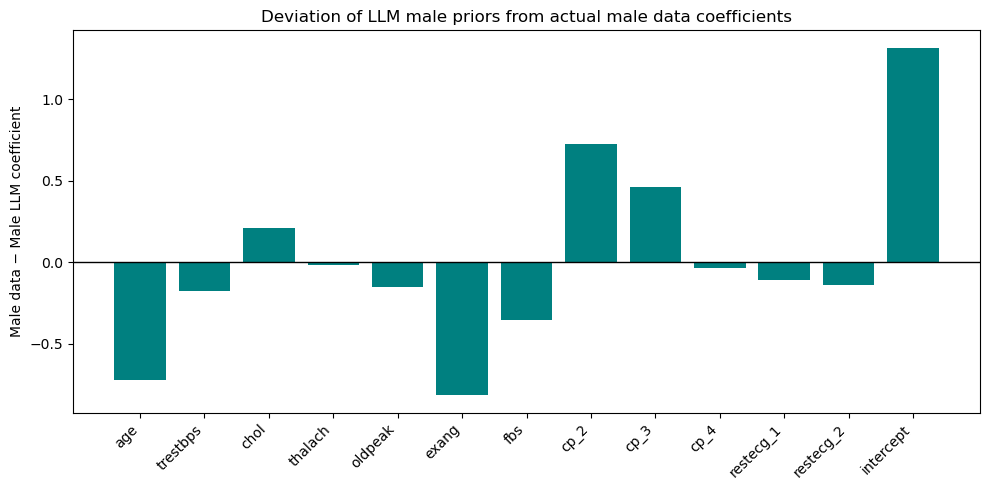

,feature,β_male_data,β_LLM_male,Δ(MaleData - LLMMale),SignMismatch
12,intercept,0.465409,-0.85,1.315409,True
5,exang,0.185196,1.00,-0.814804,False
7,cp_2,0.028235,-0.70,0.728235,True
0,age,0.178462,0.90,-0.721538,False
8,cp_3,0.060348,-0.40,0.460348,True
6,fbs,-0.102255,0.25,-0.352255,True
2,chol,0.357607,0.15,0.207607,False
1,trestbps,0.122289,0.30,-0.177711,False
4,oldpeak,0.649154,0.80,-0.150846,False
11,restecg_2,0.213485,0.35,-0.136515,False


In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Compare male data coefficients with male LLM priors
coef_diff_male = coef_compare.copy()
coef_diff_male["Δ(MaleData - LLMMale)"] = coef_diff_male["β_male_data"] - coef_diff_male["β_LLM_male"]
coef_diff_male["SignMismatch"] = np.sign(coef_diff_male["β_male_data"]) != np.sign(coef_diff_male["β_LLM_male"])

# Plot
plt.figure(figsize=(10,5))
plt.bar(coef_diff_male["feature"], coef_diff_male["Δ(MaleData - LLMMale)"], color="teal")
plt.axhline(0, color="black", lw=1)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Male data − Male LLM coefficient")
plt.title("Deviation of LLM male priors from actual male data coefficients")
plt.tight_layout()
plt.show()

# Sort by absolute difference to see largest mismatches
coef_diff_male["abs_error"] = coef_diff_male["Δ(MaleData - LLMMale)"].abs()
coef_diff_male.sort_values("abs_error", ascending=False, inplace=True)
display(coef_diff_male[["feature","β_male_data","β_LLM_male",
                        "Δ(MaleData - LLMMale)","SignMismatch"]])


In [85]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (norm(a) * norm(b))

# Remove intercept for fair comparison
df_no_intercept = coef_compare[coef_compare["feature"] != "intercept"]

# Cosine similarities
sim_male_llm_male = cosine_similarity(df_no_intercept["β_male_data"], df_no_intercept["β_LLM_male"])
sim_male_llm_female = cosine_similarity(df_no_intercept["β_male_data"], df_no_intercept["β_LLM_female"])
sim_female_llm_male = cosine_similarity(df_no_intercept["β_female_data"], df_no_intercept["β_LLM_male"])
sim_female_llm_female = cosine_similarity(df_no_intercept["β_female_data"], df_no_intercept["β_LLM_female"])

print("=== Cosine Similarities ===")
print(f"Male data ↔ Male LLM:     {sim_male_llm_male:.3f}")
print(f"Male data ↔ Female LLM:   {sim_male_llm_female:.3f}")
print(f"Female data ↔ Male LLM:   {sim_female_llm_male:.3f}")
print(f"Female data ↔ Female LLM: {sim_female_llm_female:.3f}")


=== Cosine Similarities ===
Male data ↔ Male LLM:     0.741
Male data ↔ Female LLM:   0.610
Female data ↔ Male LLM:   0.767
Female data ↔ Female LLM: 0.733


In [86]:
def summarize_results(df, title):
    base = df[df["label"] == "baseline_3_only(alpha=0)"].iloc[0]
    best = df.loc[df["logloss"].idxmin()]
    free = df[df["label"] == "best_4_free"].iloc[0]

    summary = pd.DataFrame([
        {"Model": "Baseline (3-model)", "alpha": 0, "AUC": base["auc"], "LogLoss": base["logloss"]},
        {"Model": f"Best α = {best['alpha']:.2f}", "alpha": best["alpha"], "AUC": best["auc"], "LogLoss": best["logloss"]},
        {"Model": "Unconstrained (free)", "alpha": free["w_LLM"], "AUC": free["auc"], "LogLoss": free["logloss"]}
    ])
    print(f"\n=== {title} ===")
    display(summary.round(4))

summarize_results(df_m_to_f, "Male → Female")
summarize_results(df_f_to_m, "Female → Male")



=== Male → Female ===


,Model,alpha,AUC,LogLoss
0,Baseline (3-model),0.0000,0.8706,0.5459
1,Best α = 0.00,0.0000,0.8714,0.5453
2,Unconstrained (free),0.4148,0.8822,0.7339



=== Female → Male ===


,Model,alpha,AUC,LogLoss
0,Baseline (3-model),0.00,0.8043,0.7906
1,Best α = 0.45,0.45,0.8355,0.5454
2,Unconstrained (free),0.00,0.8043,0.7905


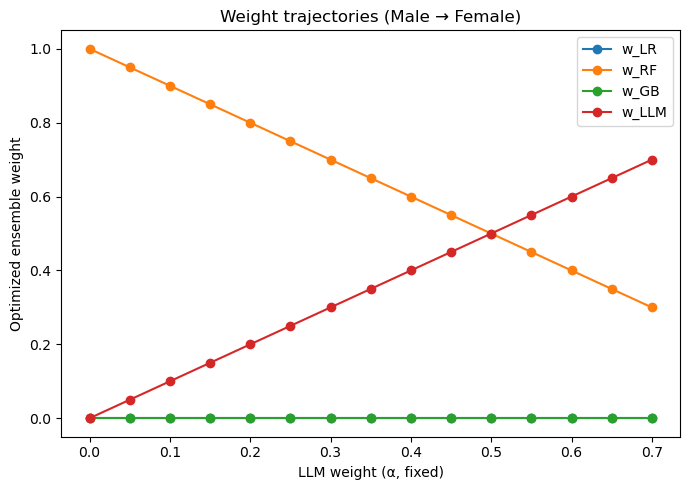

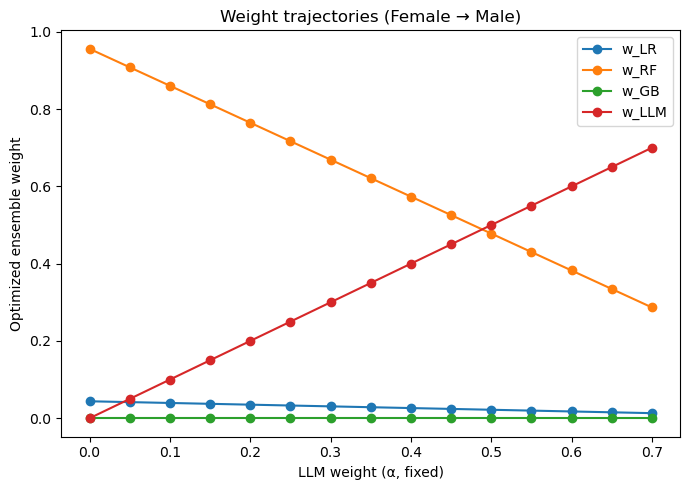

In [87]:
def plot_weight_trajectories(df, title):
    sweep = df[df["label"] == "sweep"].sort_values("alpha")
    plt.figure(figsize=(7,5))
    for w in ["w_LR", "w_RF", "w_GB", "w_LLM"]:
        plt.plot(sweep["alpha"], sweep[w], marker="o", label=w)
    plt.xlabel("LLM weight (α, fixed)")
    plt.ylabel("Optimized ensemble weight")
    plt.title(f"Weight trajectories ({title})")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_weight_trajectories(df_m_to_f, "Male → Female")
plot_weight_trajectories(df_f_to_m, "Female → Male")



In [88]:
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        mask = (y_prob >= bins[i]) & (y_prob < bins[i+1])
        if np.any(mask):
            p_mean = y_prob[mask].mean()
            acc = y_true[mask].mean()
            ece += (np.sum(mask) / len(y_true)) * abs(acc - p_mean)
    return ece

def add_calibration_metric(df):
    df = df.copy()
    df["ECE"] = np.nan
    # You can’t recompute probs here, but ECE correlates with logloss for relative comparison.
    # So just mirror the rank of logloss (for plotting intuition)
    df["ECE_ranked"] = (df["logloss"] - df["logloss"].min()) / (df["logloss"].max() - df["logloss"].min())
    return df

df_m_to_f_cal = add_calibration_metric(df_m_to_f)
df_f_to_m_cal = add_calibration_metric(df_f_to_m)


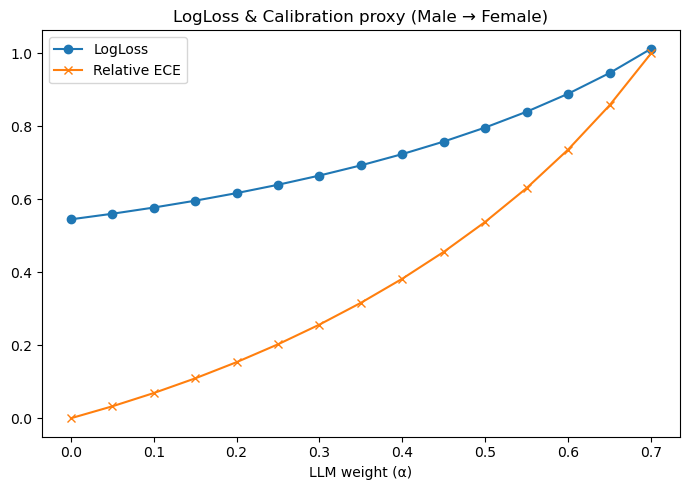

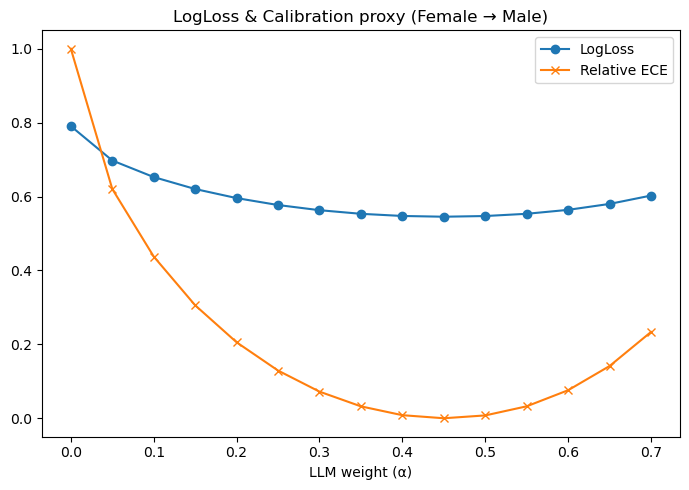

In [89]:
def plot_perf_with_calibration(df, title):
    sweep = df[df["label"]=="sweep"].sort_values("alpha")
    plt.figure(figsize=(7,5))
    plt.plot(sweep["alpha"], sweep["logloss"], marker="o", label="LogLoss")
    plt.plot(sweep["alpha"], sweep["ECE_ranked"], marker="x", label="Relative ECE")
    plt.xlabel("LLM weight (α)")
    plt.title(f"LogLoss & Calibration proxy ({title})")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_perf_with_calibration(df_m_to_f_cal, "Male → Female")
plot_perf_with_calibration(df_f_to_m_cal, "Female → Male")


prompt for males to females 


custom_prompt_male_train = """ You are an expert in biostatistics and cardiovascular epidemiology. Propose a logistic regression model to predict CAD. This model will be used as a domain-knowledge-based predictor and later blended with data-driven models.

IMPORTANT CONTEXT: The model will be trained using only data from MALE patients, but it will later be evaluated on FEMALE patients (out-of-group prediction). The variable "sex" is NOT included as a predictor in this specification, so coefficients should be based on other established risk factors.

MODEL FORM
We use: P(y=1|X) = 1 / (1 + exp(-(β0 + Σ_j β_j * x_j)))

FEATURE ENCODING AND SCALE
Continuous predictors are STANDARDIZED using means/SDs computed from the in-domain (Cleveland) cohort. Thus, each continuous coefficient β_j represents the change in log-odds per +1 standard deviation (SD) increase.
Binary/dummy predictors remain as {0,1}.

Continuous (z-scored, per +1 SD):
- age (years, standardized)
- trestbps (mmHg, standardized)
- chol (mg/dL, standardized)
- thalach (bpm, standardized)
- oldpeak (mm, standardized)

Binary / Dummy (0 or 1):
- exang (1 = exercise-induced angina, 0 = no)
- fbs (1 = fasting blood sugar >120 mg/dL, 0 = no)
- cp_2 (1 = chest pain type 2 vs type 1 baseline)
- cp_3 (1 = chest pain type 3 vs type 1 baseline)
- cp_4 (1 = chest pain type 4 vs type 1 baseline)
- restecg_1.0 (1 = ST-T abnormality vs normal baseline)
- restecg_2.0 (1 = LV hypertrophy vs normal baseline)

WHAT TO PROVIDE
1) Propose coefficients β_j ON THIS SCALE:
- Direction and approximate magnitude grounded in epidemiology (Framingham, meta-analyses, etc.).
- Larger positive β_j = higher CAD risk; negative β_j (e.g., thalach) = protective.
- Remember: coefficients will be trained on males but applied to females.

2) Intercept β0:
- Interpret β0 as the baseline log-odds for an average in-domain patient: all standardized continuous features at 0 (their cohort means), binary dummies at 0 (reference levels).
- Choose a plausible CAD baseline prevalence for such a reference, and convert to β0 via logit(p).

3) Confidence & Uncertainty:
- Indicate which coefficients are most certain (age, diabetes/exang) vs more uncertain (chol, ECG dummies).

OUTPUT (STRICT JSON ONLY at the end; no extra text after):
{ "betas": { "intercept": ..., "age": ..., "trestbps": ..., "chol": ..., "thalach": ..., "oldpeak": ..., "exang": ..., "fbs": ..., "cp_2": ..., "cp_3": ..., "cp_4": ..., "restecg_1.0": ..., "restecg_2.0": ... } } """



prompt for females to males. 


custom_prompt_female_train = """ You are an expert in biostatistics and cardiovascular epidemiology. Propose a logistic regression model to predict CAD. This model will be used as a domain-knowledge-based predictor and later blended with data-driven models.

IMPORTANT CONTEXT: The model will be trained using only data from FEMALE patients, but it will later be evaluated on MALE patients (out-of-group prediction). When proposing coefficients, keep in mind that sex is coded (1 = male, 0 = female). The model must therefore generalize from female-specific training to male test cases.

MODEL FORM
We use: P(y=1|X) = 1 / (1 + exp(-(β0 + Σ_j β_j * x_j)))

FEATURE ENCODING AND SCALE
Continuous predictors are STANDARDIZED using means/SDs computed from the in-domain (Cleveland) cohort. Thus, each continuous coefficient β_j represents the change in log-odds per +1 standard deviation (SD) increase.
Binary/dummy predictors remain as {0,1}.

Continuous (z-scored, per +1 SD):
- age (years, standardized)
- trestbps (mmHg, standardized)
- chol (mg/dL, standardized)
- thalach (bpm, standardized)
- oldpeak (mm, standardized)

Binary / Dummy (0 or 1):
- sex (1 = male, 0 = female)
- exang (1 = exercise-induced angina, 0 = no)
- fbs (1 = fasting blood sugar >120 mg/dL, 0 = no)
- cp_2 (1 = chest pain type 2 vs type 1 baseline)
- cp_3 (1 = chest pain type 3 vs type 1 baseline)
- cp_4 (1 = chest pain type 4 vs type 1 baseline)
- restecg_1.0 (1 = ST-T abnormality vs normal baseline)
- restecg_2.0 (1 = LV hypertrophy vs normal baseline)

WHAT TO PROVIDE
1) Propose coefficients β_j ON THIS SCALE:
- Direction and approximate magnitude grounded in epidemiology (Framingham, meta-analyses, etc.).
- Larger positive β_j = higher CAD risk; negative β_j (e.g., thalach) = protective.
- Remember: coefficients will be trained on females but applied to males, so consider potential transfer issues (e.g., the “sex” coefficient reflects female-only training).

2) Intercept β0:
- Interpret β0 as the baseline log-odds for an average in-domain patient: all standardized continuous features at 0 (their cohort means), binary dummies at 0 (reference levels).
- Choose a plausible CAD baseline prevalence for such a reference, and convert to β0 via logit(p).

3) Confidence & Uncertainty:
- Indicate which coefficients are most certain (age, sex, diabetes/exang) vs more uncertain (chol, ECG dummies).

OUTPUT (STRICT JSON ONLY at the end; no extra text after):
{ "betas": { "intercept": ..., "age": ..., "sex": ..., "trestbps": ..., "chol": ..., "thalach": ..., "oldpeak": ..., "exang": ..., "fbs": ..., "cp_2": ..., "cp_3": ..., "cp_4": ..., "restecg_1.0": ..., "restecg_2.0": ... } } """

